# WARNING
**Please make sure to "COPY AND EDIT NOTEBOOK" to use compatible library dependencies! DO NOT CREATE A NEW NOTEBOOK AND COPY+PASTE THE CODE - this will use latest Kaggle dependencies at the time you do that, and the code will need to be modified to make it work. Also make sure internet connectivity is enabled on your notebook**

# Preliminaries
First install critical dependencies not already on the Kaggle docker image

In [1]:
!pip install tensorflow-text

     |████████████████████████████████| 3.4 MB 870 kB/s 


Write requirements to file, anytime you run it, in case you have to go back and recover Kaggle dependencies. **MOST OF THESE REQUIREMENTS WOULD NOT BE NECESSARY FOR LOCAL INSTALLATION**

Latest known such requirements are hosted for each notebook in the companion github repo, and can be pulled down and installed here if needed. Companion github repo is located at https://github.com/azunre/transfer-learning-for-nlp

In [2]:
!pip freeze > kaggle_image_requirements.txt

In [3]:
# Import neural network libraries
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text

In [4]:
# Some other key imports
import os
import re
import pandas as pd
import numpy as np
from tqdm import tqdm

# Define Tokenization, Stop-word and Punctuation Removal Functions
Before proceeding, we must decide how many samples to draw from each class. We must also decide the maximum number of tokens per email, and the maximum length of each token. This is done by setting the following overarching hyperparameters

In [5]:
# Params for bert model and tokenization
Nsamp = 1000 # number of samples to generate in each class - 'spam', 'not spam'
maxtokens = 200 # the maximum number of tokens per document
maxtokenlen = 100 # the maximum length of each token

In [6]:
def tokenize(row):
    if row is None or row is '':
        tokens = ""
    else:
        try:
            tokens = row.split(" ")[:maxtokens]
        except:
            tokens=""
    return tokens

## Use regular expressions to remove unnecessary characters

Next, we define a function to remove punctuation marks and other nonword characters (using regular expressions) from the emails with the help of the ubiquitous python regex library. In the same step, we truncate all tokens to hyperparameter maxtokenlen defined above.

In [7]:
def reg_expressions(row):
    tokens = []
    try:
        for token in row:
            token = token.lower()
            token = re.sub(r'[\W\d]', "", token)
            token = token[:maxtokenlen] # truncate token
            tokens.append(token)
    except:
        token = ""
        tokens.append(token)
    return tokens

## Stop-word removal

Let’s define a function to remove stopwords - words that occur so frequently in language that they offer no useful information for classification. This includes words such as “the” and “are”, and the popular library NLTK provides a heavily-used list that will employ.

In [8]:
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')    
print(stopwords) # see default stopwords

def stop_word_removal(row):
    token = [token for token in row if token not in stopwords]
    token = filter(None, token)
    return token

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any'

# Read and Preprocess Enron dataset
Read Enron dataset and get a sense for the data by printing sample messages to screen

add Codeadd Markdown

In [9]:
# Input data files are available in the "../input/" directory.
filepath = "../input/enron-email-dataset/emails.csv"

# Read the data into a pandas dataframe called emails
emails = pd.read_csv(filepath)

print("Successfully loaded {} rows and {} columns!".format(emails.shape[0], emails.shape[1]))
print(emails.head())

Successfully loaded 517401 rows and 2 columns!
                       file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...


In [10]:
# take a closer look at the first email
print(emails.loc[0]["message"])

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


In [11]:
# Separate headers from the message bodies
import email

def extract_messages(df):
    messages = []
    for item in df["message"]:
        # Return a message object structure from a string
        e = email.message_from_string(item)    
        # get message body  
        message_body = e.get_payload()
        messages.append(message_body)
    print("Successfully retrieved message body from e-mails!")
    return messages

bodies = extract_messages(emails)

Successfully retrieved message body from e-mails!


In [12]:
# extract random 10000 enron email bodies for building dataset
import random
bodies_df = pd.DataFrame(random.sample(bodies, 10000))

# expand default pandas display options to make emails more clearly visible when printed
pd.set_option('display.max_colwidth', 300)

bodies_df.head() # you could do print(bodies_df.head()), but Jupyter displays this nicer for pandas DataFrames

,0
0,"Thanks for all the efforts, diligence and perseverance to get this money that was owed the company. \n\nGreat job by all\n\nLD\n\n-----Original Message-----\nFrom: Ashland, Team \nSent: Thursday, October 25, 2001 1:19 PM\nTo: Noyes, David; Stephens, LD\nCc: Miller, Dave W; Howard, Randy; Reed, R..."
1,"Italy\n\nThis is not very illustrative example. Utilities (ENEL distcos and \nmunicipalities) will not be allowed to sign long-term supply contracts with \nproducers (ENEL gensets or divested ENEL gensets). Even, according to the \nlast draft of market design recently published by the regulator,..."
2,"What is the status of Coral Energy Canada Inc. and Enserch Energy Canada LP?\n\n\n\nDebra Perlingiere\nEnron North America Corp.\n1400 Smith Street, EB 3885\nHouston, Texas 77002\ndperlin@enron.com\nPhone 713-853-7658\nFax 713-646-3490"
3,"FYI\n\nVince\n\n -----Original Message-----\nFrom: \tThode, Eric \nSent:\tWednesday, August 15, 2001 9:18 AM\nTo:\tKaminski, Vince J\nSubject:\tResearch Employees We Haven't Heard From\n\nVince --\n\nThese are the Research employees I still have as outstanding in the system. Are these all corr..."
4,"\n\n-----Original Message-----\nFrom: Trevino, Susan \nSent: Friday, April 12, 2002 11:30 AM\nTo: faulkjb@texaco.com; Green, Michael; gregory.schockling@bhlp.com;\nHagelmann, Bjorn; hugh.connett@bhlp.com; maedajr@texaco.com; Mihalik,\nTrevor; Miller, Don (Asset Mktg); randall.curry@bhlp.com; Zis..."


# Read and Preprocess Fraudulent "419" Email Corpus

In [13]:
filepath = "../input/fraudulent-email-corpus/fradulent_emails.txt"
with open(filepath, 'r',encoding="latin1") as file:
    data = file.read()
    
# split on a code word appearing close to the beginning of each email
fraud_emails = data.split("From r")

print("Successfully loaded {} spam emails!".format(len(fraud_emails)))

Successfully loaded 3978 spam emails!


In [14]:
fraud_bodies = extract_messages(pd.DataFrame(fraud_emails,columns=["message"],dtype=str))
fraud_bodies_df = pd.DataFrame(fraud_bodies[1:])

fraud_bodies_df.head() # you could do print(fraud_bodies_df.head()), but Jupyter displays this nicer for pandas DataFrames

Successfully retrieved message body from e-mails!


,0
0,"FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-27-587908.\nE-MAIL: (james_ngola2002@maktoob.com).\n\nURGENT BUSINESS ASSISTANCE AND PARTNERSHIP.\n\n\nDEAR FRIEND,\n\nI AM ( DR.) JAMES NGOLA, THE PERSONAL ASSISTANCE TO THE LATE CONGOLESE (PRESIDENT LAURENT KABILA) WHO WAS ASSASSINATED BY HIS BODY G..."
1,"Dear Friend,\n\nI am Mr. Ben Suleman a custom officer and work as Assistant controller of the Customs and Excise department Of the Federal Ministry of Internal Affairs stationed at the Murtala Mohammed International Airport, Ikeja, Lagos-Nigeria.\n\nAfter the sudden death of the former Head of s..."
2,"FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF ELEME KINGDOM \nCHIEF DANIEL ELEME, PHD, EZE 1 OF ELEME.E-MAIL \nADDRESS:obong_715@epatra.com \n\nATTENTION:PRESIDENT,CEO Sir/ Madam. \n\nThis letter might surprise you because we have met\nneither in person nor by correspondence. But I believe\nit is..."
3,"FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF ELEME KINGDOM \nCHIEF DANIEL ELEME, PHD, EZE 1 OF ELEME.E-MAIL \nADDRESS:obong_715@epatra.com \n\nATTENTION:PRESIDENT,CEO Sir/ Madam. \n\nThis letter might surprise you because we have met\nneither in person nor by correspondence. But I believe\nit is..."
4,"Dear sir, \n \nIt is with a heart full of hope that I write to seek your help in respect of the context below. I am Mrs. Maryam Abacha the former first lady of the former Military Head of State of Nigeria General Sani Abacha whose sudden death occurred on 8th of June 1998 as a result of cardiac ..."


# Putting It All Together To Assemble Dataset
Now, putting all the preprocessing steps together we assemble our dataset...

In [15]:
import random

# Convert everything to lower-case, truncate to maxtokens and truncate each token to maxtokenlen
EnronEmails = bodies_df.iloc[:,0].apply(tokenize)
EnronEmails = EnronEmails.apply(stop_word_removal)
EnronEmails = EnronEmails.apply(reg_expressions)
EnronEmails = EnronEmails.sample(Nsamp)

SpamEmails = fraud_bodies_df.iloc[:,0].apply(tokenize)
SpamEmails = SpamEmails.apply(stop_word_removal)
SpamEmails = SpamEmails.apply(reg_expressions)
SpamEmails = SpamEmails.sample(Nsamp)

raw_data = pd.concat([SpamEmails,EnronEmails], axis=0).values

In [16]:
print("Shape of combined data represented as numpy array is:")
print(raw_data.shape)
print("Data represented as numpy array is:")
print(raw_data)

# corresponding labels
Categories = ['spam','notspam']
header = ([1]*Nsamp)
header.extend(([0]*Nsamp))

Shape of combined data represented as numpy array is:
(2000,)
Data represented as numpy array is:
[list([])
 list(['contenttype', 'textplainmessageid', 'aebdwebstreamingnetdate', 'sun', '', 'feb', '', '', '', 'cetcontenttransferencoding', 'quotedprintableddear', 'friend', 'ddmy', 'name', 'mrs', 'xian', 'i', 'bank', 'manager', 'reputable', 'bank', 'china', 'i', 'would', 'respectfully', 'request', 'keep', 'contents', 'mail', 'confidential', 'respect', 'integrity', 'information', 'come', 'result', 'mail', 'i', 'contacted', 'independently', 'investigation', 'and', 'one', 'informed', 'communication', 'ddthe', 'subject', 'questions', 'client', 'bank', 'demise', 'he', 'maintained', 'investment', 'millions', 'dollars', 'since', 'reached', 'maturity', 'the', 'subject', 'maintained', 'discrete', 'relationship', 'us', 'and', 'never', 'nominated', 'legatee', 'investment', 'at', 'time', 'demise', 'he', 'yet', 'sign', 'mandate', 'card', 'remained', 'testate', 'it', 'ethical', 'investment', 'us', 'co

In [17]:
# function for shuffling data in unison with labels/header
def unison_shuffle(a, b):
    p = np.random.permutation(len(b))
    data = a[p]
    header = np.asarray(b)[p]
    return data, header

# function for converting data into the right format, due to the difference in required format from sklearn models
# we expect a single string per email here, versus a list of tokens for the sklearn models previously explored
def convert_data(raw_data,header):
    converted_data, labels = [], []
    for i in range(raw_data.shape[0]):
        out = ' '.join(raw_data[i])
        converted_data.append(out)
        labels.append(header[i])
        #print(i)
    converted_data = np.array(converted_data, dtype=object)[:, np.newaxis]
    
    return converted_data, np.array(labels)

raw_data, header = unison_shuffle(raw_data, header)

# split into independent 70% training and 30% testing sets
idx = int(0.7*raw_data.shape[0])
# 70% of data for training
train_x, train_y = convert_data(raw_data[:idx],header[:idx])
# remaining 30% for testing
test_x, test_y = convert_data(raw_data[idx:],header[idx:])

print("train_x/train_y list details, to make sure it is of the right form:")
print(len(train_x))
print(train_x)
print(train_y[:5])
print(train_y.shape)

train_x/train_y list details, to make sure it is of the right form:
1400
[['hi katie i feeling good status deals looks like close next wednesday so stands now i think i work this weekend of course i said that almost positive something come uphmmm actually work might bad thing alternative helping roommate pack stuff move north carolinahave great weekend talk soongerald']
 ['my dear friendcmy name mremusa ae zuluc managerc creditand foreign bills african development bank plcei writing respect foreign customer ofmy bank account number kfadb whoperished plane crash bkorean air flight dwith whole passengers aboard august c esince demise customerc i could care lessaboutci personallyhave watched keen interest see next kinbut proved abortive one come toclaim funds use mc bfifty seven millionunited states dollarsd branchfor long timeeon notec i decided seek namecould used next kin one come upto next kine and banking ethics heredoes allow money stay sevenyearsc money recalled banktreasury unclai

# Build, Train and Evaluate BERT Model
First define critical functions that define various components of the BERT model

In [18]:
# Function to build overall model
def build_model(max_seq_length):
    # tf hub bert model path
    bert_path = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4" 

    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
    
    
    preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
    encoder_inputs = preprocessor(text_input)
    encoder = hub.KerasLayer(bert_path,trainable=False)
    outputs = encoder(encoder_inputs)
    pooled_output = outputs["pooled_output"]      # [batch_size, 768].
    sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].# just extract BERT features
    
    # train dense classification layer on top of extracted pooled output features
    dense = tf.keras.layers.Dense(256, activation="relu")(pooled_output)
    pred = tf.keras.layers.Dense(1, activation="sigmoid")(dense)

    model = tf.keras.Model(inputs=text_input, outputs=pred)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.summary()

    return model

In [19]:
# Build model
model = build_model(maxtokens)

# Instantiate variables
#initialize_vars(sess)

# Train model
history = model.fit(train_x,train_y,validation_data=(test_x,test_y),epochs=5,batch_size=32)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_word_ids': ( 0           input_1[0][0]                    
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'encoder_outputs':  109482241   keras_layer[0][0]                
                                                                 keras_layer[0][1]                
                                                                 keras_layer[0][2]                
______________________________________________________________________________________________

# Visualize and Save Convergence Info

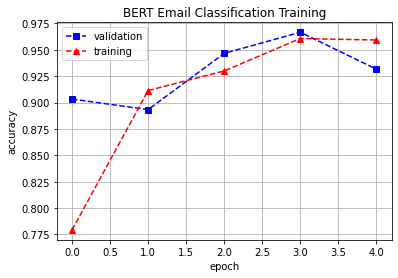

In [20]:
import matplotlib.pyplot as plt

df_history = pd.DataFrame(history.history)
fig,ax = plt.subplots()
plt.plot(range(df_history.shape[0]),df_history['val_accuracy'],'bs--',label='validation')
plt.plot(range(df_history.shape[0]),df_history['accuracy'],'r^--',label='training')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('BERT Email Classification Training')
plt.legend(loc='best')
plt.grid()
plt.show()

fig.savefig('BERTConvergence.eps', format='eps')
fig.savefig('BERTConvergence.pdf', format='pdf')
fig.savefig('BERTConvergence.png', format='png')
fig.savefig('BERTConvergence.svg', format='svg')

In [21]:
from IPython.display import HTML
def create_download_link(title = "Download file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

create_download_link(filename='BERTConvergence.svg')